# Ripple NRTidalv3 verification notebook

In [278]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt, PI
from ripple.waveforms.utils_tidal import get_quadparam_octparam
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

# import lalsimulation as lalsim
# import lal

from ripple import get_eff_pads

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv3

params = {"axes.grid": True,
        "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)


jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
m1 = 3
m2 = 3

chi1 = 0.0
chi2 = 0.0

lambda1 = 1000.0
lambda2 = 1000.0

distance = 440.

Get the frequency grid:

In [280]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
# df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [281]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0 # np.pi / 2
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv3.gen_NRTidalv3_hphc(fs_ripple, theta_ripple, f_ref)

## LAL

Built LAL from source in order to get access to the as of yet unreleased NRTidalv3. We trust the ripple implementation to compute quad parameter (verified by NRTidalv2).

In [282]:
quad1, _ = get_quadparam_octparam(lambda1)
quad2, _ = get_quadparam_octparam(lambda2)

dquadmon1 = quad1 - 1
dquadmon2 = quad2 - 1

In [283]:
# os.system("lalsim-inspiral --help")

In [284]:
# Build the command string to call LAL
IMRphenom = "IMRPhenomD_NRTidalv3"
f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

### TODO needed?
# m1_kg = m1 * lal.MSUN_SI
# m2_kg = m2 * lal.MSUN_SI
# distance = dist_mpc * 1e6 * lal.PC_SI

In [285]:
### TODO remove?
# result = subprocess.run(command_string, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
# output = result.stdout
# small_output = output[:993]
# lines = output.split('\n')[1:-1] # skip the header and the last line, which is empty

# # f, hp_real, hp_imag, hx_real, hx_imag
# result = np.array([list(map(float, line.split('\t'))) for line in lines])
# f = result[:, 0]
# hp_real = result[:, 1]
# hp_imag = result[:, 2]
# hx_real = result[:, 3]
# hx_imag = result[:, 4]

In [286]:
# def get_lal_hp(m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, inclination, f_l, f_sampling, f_ref=None, IMRphenom = "IMRPhenomD_NRTidalv3"):
    
#     if f_ref is None:
#         f_ref = f_l
    
#     quad1, _ = get_quadparam_octparam(lambda1)
#     quad2, _ = get_quadparam_octparam(lambda2)

#     dquadmon1 = quad1 - 1
#     dquadmon2 = quad2 - 1
#     command_string = f"lalsim-inspiral -F -a {IMRphenom} -M {m1} -m {m2} -d {dist_mpc} -i {inclination} -Z {chi1} -z {chi2} -L {lambda1} -l {lambda2} -Q {dquadmon1} -q {dquadmon2} -R {f_sampling} -f {f_l} -r {f_ref}"
    
#     print(command_string)
    
#     # Run the bash command
#     result = subprocess.run(command_string, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE) # , universal_newlines=True
#     output = result.stdout
    
#     # Skip the header and the last line, which is empty
#     lines = output.split('\n')[1:-1]

#     # Get the result as f, hp_real, hp_imag, hx_real, hx_imag
#     result = np.array([list(map(float, line.split('\t'))) for line in lines])
#     f       = result[:, 0]
#     hp_real = result[:, 1]
#     hp_imag = result[:, 2]
#     hx_real = result[:, 3]
#     hx_imag = result[:, 4]
    
#     return f, hp_real, hp_imag, hx_real, hx_imag

In [287]:
# freqs_lal, hp_real, hp_imag, hx_real, hx_imag = get_lal_hp(m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, inclination, f_l, f_sampling, f_ref)
# hp_lalsuite = hp_real + hp_imag * 1.0j

# # freqs_lal = np.arange(len(hp_lalsuite)) * df

# # mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
# # hp_lalsuite = hp_lalsuite[mask_lal]

In [288]:
### THis does not work, use the work around script instead
lalsuite_env_script = "/Users/Woute029/Documents/Code/nrtidalv3_20231031/_inst/etc/lalsuite-user-env.sh"
# command = f"source {lalsuite_env_script}"
# command = f"source {lalsuite_env_script}; python calculate_nrtidalv3_waveform.py"
# out = subprocess.run(command, shell=True)
# print(out.returncode)

In [289]:
def get_hp_lalsuite(m1, m2, chi1, chi2, lambda1, lambda2, distance, T, f_l, f_sampling, inclination):
    command = f"source {lalsuite_env_script}; python calculate_nrtidalv3_waveform.py --m1 {m1} --m2 {m2} --chi1 {chi1} --chi2 {chi2} --lambda1 {lambda1} --lambda2 {lambda2} --distance {distance} --T {T} --f_l {f_l} --f_sampling {f_sampling} --inclination {inclination}"
    print(command)
    out = subprocess.run(command, shell=True)
    print(out.returncode)
    
    hp = np.load("hp.npy")
    
    return hp

In [290]:
# import lalsimulation as lalsim
# import lal
hp = get_hp_lalsuite(m1, m2, chi1, chi2, lambda1, lambda2, distance, T, f_l, f_sampling, inclination)
freqs_lal = np.arange(len(hp)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
f = freqs_lal[mask_lal]
hp_lalsuite = hp[mask_lal]

source /Users/Woute029/Documents/Code/nrtidalv3_20231031/_inst/etc/lalsuite-user-env.sh; python calculate_nrtidalv3_waveform.py --m1 3 --m2 3 --chi1 0.0 --chi2 0.0 --lambda1 1000.0 --lambda2 1000.0 --distance 440.0 --T 16 --f_l 20.0 --f_sampling 4096 --inclination 0
0


In [291]:
# # Get the tidal parameters ready
# laldict = lal.CreateDict()
# lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
# lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
# quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
# quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# # print(quad1)
# oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
# oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# # print(oct1)
# lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
# lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)


# IMRphenom = "IMRPhenomD_NRTidalv3"
# approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

# f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

# theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

# m1_kg = theta[0] * lal.MSUN_SI
# m2_kg = theta[1] * lal.MSUN_SI
# distance = dist_mpc * 1e6 * lal.PC_SI

# hp, _ = lalsim.SimInspiralChooseFDWaveform(
#     m1_kg,
#     m2_kg,
#     0.0,
#     0.0,
#     chi1,
#     0.0,
#     0.0,
#     chi2,
#     distance,
#     inclination,
#     phic,
#     0,
#     0,
#     0,
#     df,
#     f_l,
#     f_u,
#     f_ref,
#     laldict,
#     approximant,
# )
# freqs_lal = np.arange(len(hp.data.data)) * df

# mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
# hp_lalsuite = hp.data.data[mask_lal]

## Comparison

In [292]:
# f = freqs_lal[mask_lal]

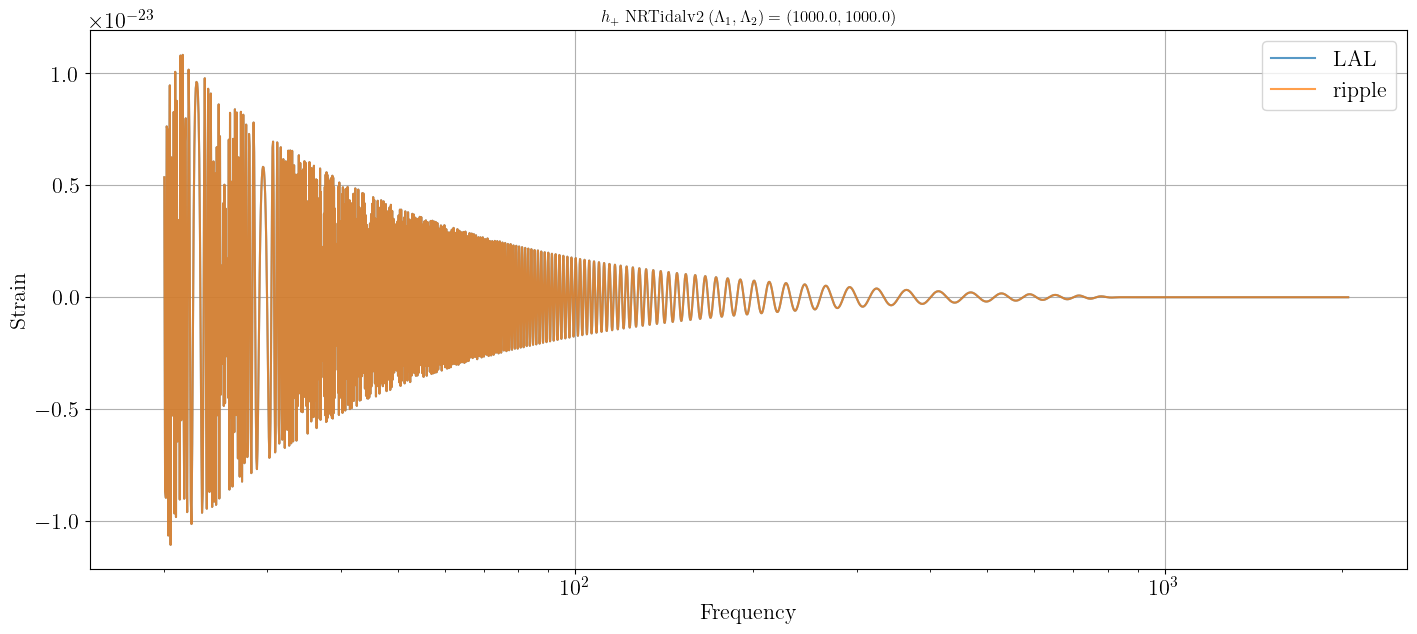

In [293]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7)) 
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv3 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

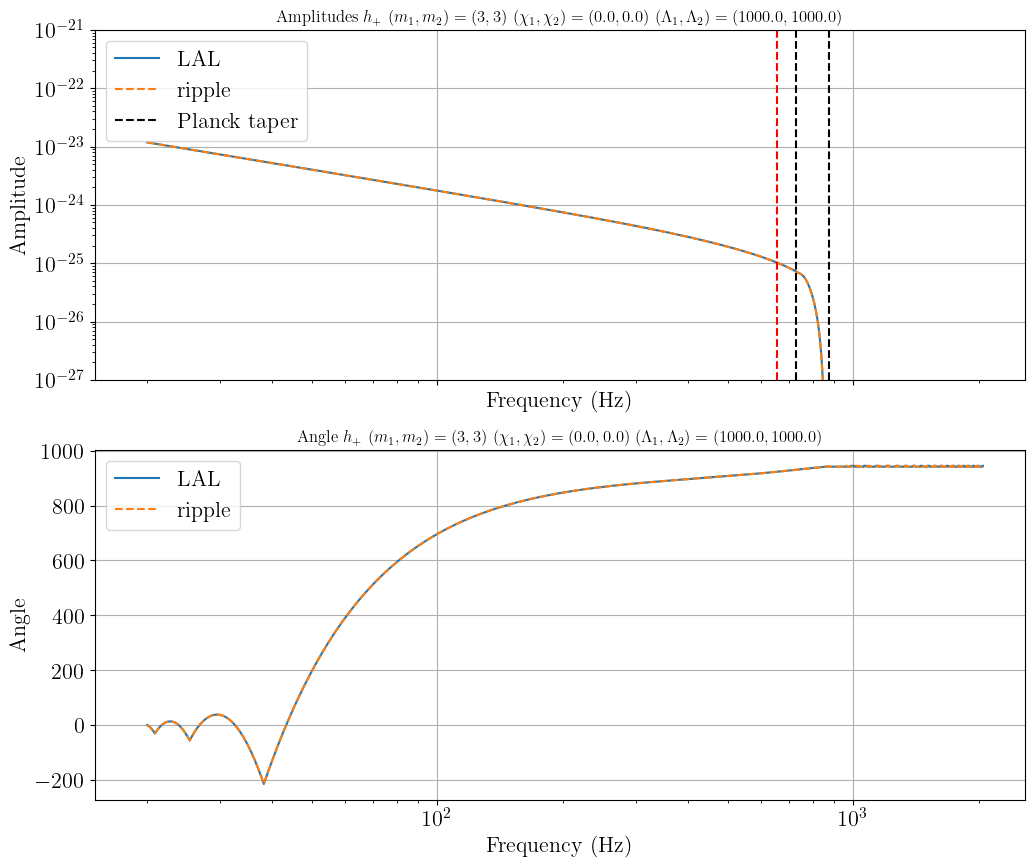

In [294]:
## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
merger_params = jnp.array([m1, m2, chi1, chi2, lambda1, lambda1])
f_merger = X_NRTidalv3._get_merger_frequency(merger_params)
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')
plt.axvline(0.9 * f_merger, linestyle = "--", color = 'red')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

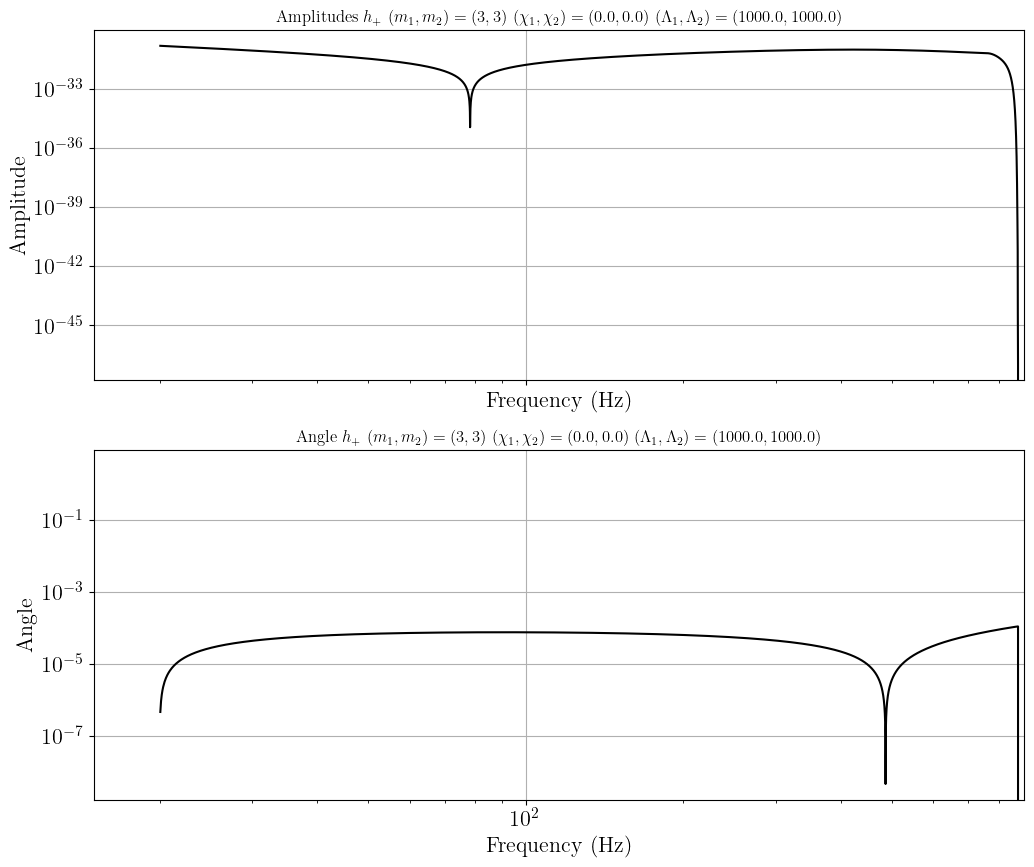

In [295]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Computing mismatch

In [296]:
from ripple import get_match_arr

In [297]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(match)
print(np.log10(1 - match))

0.9999999999021615
-10.009490147375395


## Debugging

Checking if computations match very precisely

In [298]:
# print("LAL quad and oct")
# print(quad1)
# print(oct1)

# print("Ripple quad and oct")
# quad, oct = get_quadparam_octparam(lambda1)
# print(quad)
# print(oct)

# print("Absolute differences")
# print(abs(quad - quad1))
# print(abs(oct - oct1))

# print("LAL kappa")
# kappa_lal = lalsim.SimNRTunedTidesComputeKappa2T(m1_kg, m2_kg, lambda1, lambda2)
# print(kappa_lal)

# print("Ripple kappa")
# kappa_ripple = X_NRTidalv3.get_kappa(jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))
# print(kappa_ripple)

# print("Absolute differences")
# print(abs(kappa_lal - kappa_ripple))

# print("LAL f merger")
# f_merger_lal = lalsim.SimNRTunedTidesMergerFrequency(m1+m2, kappa_lal, m1/m2)
# print(f_merger_lal)

# print("Ripple f merger")
# f_merger_ripple = X_NRTidalv3._get_merger_frequency(jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))
# print(f_merger_ripple)

# print("Absolute differences")
# print(abs(f_merger_ripple - f_merger_lal))

In [299]:
# M = m1 + m2
# M_s = M * gt
# test1 = lalsim.SimInspiralGetHOSpinTerms(m1/M, m2/M, chi1, chi2, quad1, quad2)

In [300]:
# test1

In [301]:
# x = (PI * M_s * f) ** (2.0/3.0)
# test = X_NRTidalv3.get_spin_phase_correction(x, jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))